This is my walkalong of the BayesFlow Quickstart guide: https://bayesflow.org/_examples/Intro_Amortized_Posterior_Estimation.html#table-of-contents

In [1]:
import numpy as np
import bayesflow as bf

/Users/lasse/miniconda3/envs/bayesflow/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Defining the Generative Model

In [2]:
seed = 1999
RNG = np.random.default_rng(seed)

The toy model in this walkalong is doing inference on D Gaussian means

$$ \bf{\mu} \sim \mathcal{N}_D(\bf{0}, \bf{I}) $$
$$ \bf{x}_n \sim \mathcal{N}_D(\bf{\mu}, \bf{I}) \quad \text{for} \quad n=1,2,\ldots,N $$

where $\bf{\mu}$ is a D-dimensional vector of means, $\bf{x}_n$ is a D-dimensional vector of observations, and $\bf{I}$ is the D-dimensional identity matrix. The goal is to do inference on the means $\bf{\mu}$ given the observations $\bf{x}_n$. 

In [5]:
# prior function generating draws from prior
def prior_func(D=4):
    return RNG.normal(size = D)

# pass to prior wrapper from bayesflow
prior = bf.simulation.Prior(prior_fun = prior_func)

We can now sample any amount of draws from the prior. The prior and the likelihood under the prior will be used to train the neural net.

In [6]:
prior(batch_size=3)

{'prior_draws': array([[-0.78873063,  0.9836855 ,  0.46385128, -0.18190313],
        [ 0.13811025, -0.33853958, -0.02294729,  1.35390042],
        [ 0.26656641,  1.97482765,  1.10316537, -0.21072483]]),
 'batchable_context': None,
 'non_batchable_context': None}

Next is the **simulator** - aka the **likelihood**. 

They use the word "simulator" because, as I understood Marvin Schmitt in the ABI podcast episode, the whole approach of amorized bayesian inference was borne out of simulated-based inference where you do not have access to a closed form probability function and associated densities. But in standard Bayesian terminology, this is essentially the likelihood, that we *implicitely* define it through our "simulating" sampling function.

In [7]:
def likelihood_func(params, n_obs=50):
    return RNG.normal(loc = params, size = (n_obs, params.shape[0]))

Here, `n_obs` is the number of observations that we will generate from the likelihood for each draw from the prior.

In [8]:
simulator = bf.simulation.Simulator(simulator_fun = likelihood_func)

We can now connect the two via the `GenerativeModel` class.

In [9]:
model = bf.simulation.GenerativeModel(prior = prior, simulator = simulator)

INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 50, 4)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


One can specify and work with additional context variables that the prior and posterior will be conditional on. I do not look at them further here.

In [11]:
out = model(batch_size=3)
out["prior_draws"]

array([[-0.5884027 , -1.42042635,  0.04291808, -1.11703724],
       [-0.22101772,  2.05738539, -1.10649752, -0.82555604],
       [-0.32995203,  0.43434706,  0.72788338,  1.7491938 ]])

In [13]:
out["sim_data"].shape

(3, 50, 4)

For each batch, we get a prior draw for each mean, and then we generate `n_obs=50` observations observations from the likelihood for each mean. So rows are simulated observations based on the likelihood under the prior, and columns are prior means. If we take column means, they are therefore are quite close to the corresponding prior means for that batch.

In [17]:
out["sim_data"][0].mean(axis = 0)

array([-0.6649234 , -1.34297624,  0.19729526, -1.16138364])

# Defining the Neural Approximator

## Summary Network

We can now train the `Summary Network`

> Since our likelihood generates data exchangeably, we need to respect the permutation invariance of the data. Exchangeability in data means that the probability distribution of a sequence of observations remains the same regardless of the order in which the observations appear. In other words, the data is permutation invariant. For that, we will use a DeepSet which does exactly that. This network will take (at least) 3D tensors of shape (batch_size, n_obs, D) and reduce them to 2D tensors of shape (batch_size, summary_dim), where summary_dim is a hyperparameter to be set by the user (you). Heuristically, this number should not be lower than the number of parameters in a model.

In [18]:
summary_net = bf.networks.DeepSet(summary_dim=10)

In [20]:
test_input = model(batch_size=3)
summary_representation = summary_net(test_input["sim_data"]).numpy()
summary_representation

array([[-0.00329084,  0.00840237,  0.02503048, -0.00060299, -0.0001216 ,
        -0.01852962,  0.00190498, -0.041552  , -0.00502702, -0.01142572],
       [ 0.00130561,  0.01445241,  0.02053887, -0.00184933,  0.00811669,
        -0.02196399,  0.00105114, -0.02688026, -0.0057567 , -0.0045191 ],
       [-0.00184187,  0.01467652,  0.02316919, -0.00795459,  0.00111232,
        -0.02131344, -0.00565464, -0.03623552, -0.00592399, -0.01185123]],
      dtype=float32)

We see that for each batch, the `SummaryNetwork` has reduced the `(50,4)` tensor to a `(10,)` tensor. This is the summary vector for each batch. 
> Upon convergence of the simulation-based training, which these summary vectors will enter, one could think about this as learning some form of data embedding, or summary statistics of the data.

## Inference Network

The inference network is responsible for learning the true posterior of model parameters given the summary statistics of
the observed data.

> Next, we define the main workhorse of our our framework for amortized posterior inference - the conditional invertible neural network (cINN). The only mandatory hyperparameter for the `InvertibleNetwork` is the number of parameters we aim to estimate, in our case `num_params = 4`.

**Regularization**

There are many other hyperparameters that can be set. Most important apparently are the `num_params` and the `num_coupling_layers` which determines the expressiveness (performance) of the network. There is also a small mention of the use of regularization, which they advertise for offline learning when data is pre-simulated (as it would be in our simulation study)?

In [21]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=4,
    num_coupling_layers=4,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False}, # no L2 and no dropout regularization
)

We can inspect the raw outputs of the cINN by feeding it the parameter draws and corresponding data summaries.

>This network is slightly more involved than the summary network, as it has two mandatory inputs: `targets` and `condition`. It also has two outputs: `z` and `log_det_J`, which represent the latent representation of the parameters and the log of the Jacobian determinant, respectively.

-> So the `condition` is the summary vector that we have obtained from the `SummaryNetwork`, and the `targets` are the prior draws that generated the draws which in turn was used to generate the summary vector.

In [ ]:
z, log_det_J = inference_net(test_input["prior_draws"], summary_representation)

`z` has the same shape as the `targets` (here our gaussian means), and represents the latent representation of the parameters.

In [28]:
z.numpy()

array([[-1.2961979 ,  0.6029867 ,  1.153573  , -1.8821021 ],
       [ 1.110555  ,  1.2629082 , -0.31027892, -0.95223606],
       [ 0.18093665,  0.8510844 ,  1.7943687 ,  0.7466884 ]],
      dtype=float32)

In [29]:
print("Shape of latent variables:", z.numpy().shape)
print("Shape of log det Jacobian:", log_det_J.numpy().shape)

Shape of latent variables: (3, 4)
Shape of log det Jacobian: (3,)


## Amortized Posterior

We can now connect the `summary_net` and the `invertible_net` via the `AmortizedPosterior` class.

>This wrapper knows how to compute its loss function, draw samples from the approximate posterior given new data and also compute normalized posterior densities

In [26]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

# Defining the Trainer

> The Trainer instance connects a generative model with an amortizer and enables various types of simulation-based training

In [27]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


A `Trainer` does more than just connect the two elements. It also sets the `configurator`, which in this simple model is inferred, but for more complicated models should be explicitely defined.

>What does a configurator do? It takes the raw outputs of the generative models and turns them into something with which neural networks can work.

Thus, they are kind of the glue between the generative model and the neural network.

In [31]:
# recall: out = model(batch_size=3) above
configurator_out = trainer.configurator(out)
print("Keys of configured dict: ", list(configurator_out.keys()))

Keys of configured dict:  ['summary_conditions', 'direct_conditions', 'parameters']


The default configurator for posterior inference differentiates between three types of model outputs:

1. `parameters` - these are the quantities for which we want posteriors.
2. `summary_conditions` - these are the quantities that go through the summary network (typically the raw data).
3. `direct_conditions` – these are concatenated with the outputs of the summary network and passed directly to the inference network.

In [34]:
print(np.allclose(out["sim_data"], configurator_out["summary_conditions"]))
print(np.allclose(out["prior_draws"], configurator_out["parameters"]))

True
True


# Training phase

Here we will do on-line training, where we generate data on the fly. We can also do off-line training, where we have pre-simulated data. The former training regime:
> is optimal for fast generative models which can efficiently simulate

In [35]:
%%time
history = trainer.train_online(epochs=5, iterations_per_epoch=500, batch_size=32, validation_sims=200)

INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 500/500 [00:09<00:00, 50.16it/s, Epoch: 1, Iter: 500,Loss: 2.221,Avg.Loss: 2.873,LR: 4.52E-04]
INFO:root:Validation, Epoch: 1, Loss: 2.162
Training epoch 2: 100%|██████████| 500/500 [00:05<00:00, 84.82it/s, Epoch: 2, Iter: 500,Loss: 2.155,Avg.Loss: 2.039,LR: 3.28E-04]
INFO:root:Validation, Epoch: 2, Loss: 1.939
Training epoch 3: 100%|██████████| 500/500 [00:05<00:00, 83.73it/s, Epoch: 3, Iter: 500,Loss: 1.724,Avg.Loss: 1.851,LR: 1.73E-04]
INFO:root:Validation, Epoch: 3, Loss: 1.643
Training epoch 4: 100%|██████████| 500/500 [00:05<00:00, 83.67it/s, Epoch: 4, Iter: 500,Loss: -0.034,Avg.Loss: 0.659,LR: 4.79E-05]
INFO:root:Validation, Epoch: 4, Loss: -0.011
Training epoch 5: 100%|██████████| 500/500 [00:06<00:00, 82.36it/s, Epoch: 5, Iter: 500,Loss: -0.384,Avg.Loss: -0.047,LR: 1.94E-10]
INFO:root:Validation, Epoch: 5, Loss: -0.191


CPU times: user 46.4 s, sys: 10.3 s, total: 56.6 s
Wall time: 34.6 s


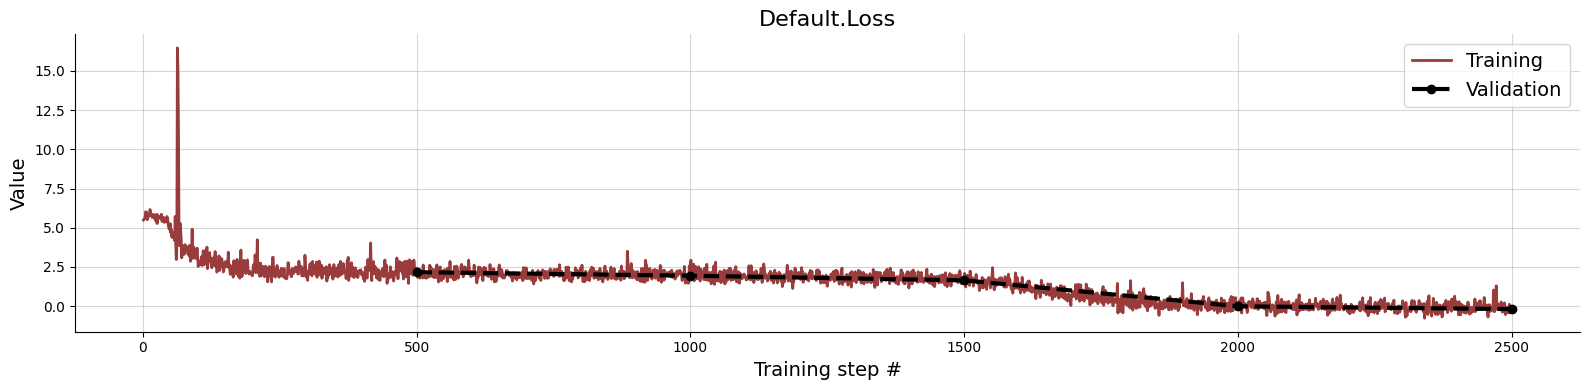

In [36]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)

# Obtain posterior samples

The idea is that we can now obtain posterior samples for the means given any set of observables.

In [58]:
test_sims = trainer.configurator(model(500))
print(list(test_sims.keys()))

['summary_conditions', 'direct_conditions', 'parameters']


In [59]:
# obtain 100 posterior samples for each simulated data set in the 500 test_sim data sets (batches)
posterior_samples = amortizer.sample(test_sims, n_samples = 1000)

In [60]:
posterior_samples.shape

(500, 1000, 4)

### Simulation based calibration

> SBC is a technique used to assess whether a probabilistic model correctly infers parameters from data. The basic idea is to simulate a large number of datasets from the model’s prior distribution and then perform posterior inference on these simulated datasets. The goal is to check if the inferred posterior distributions are consistent with the priors. Essentially, SBC tests if the model can accurately recover the parameters it used to generate the data in the first place

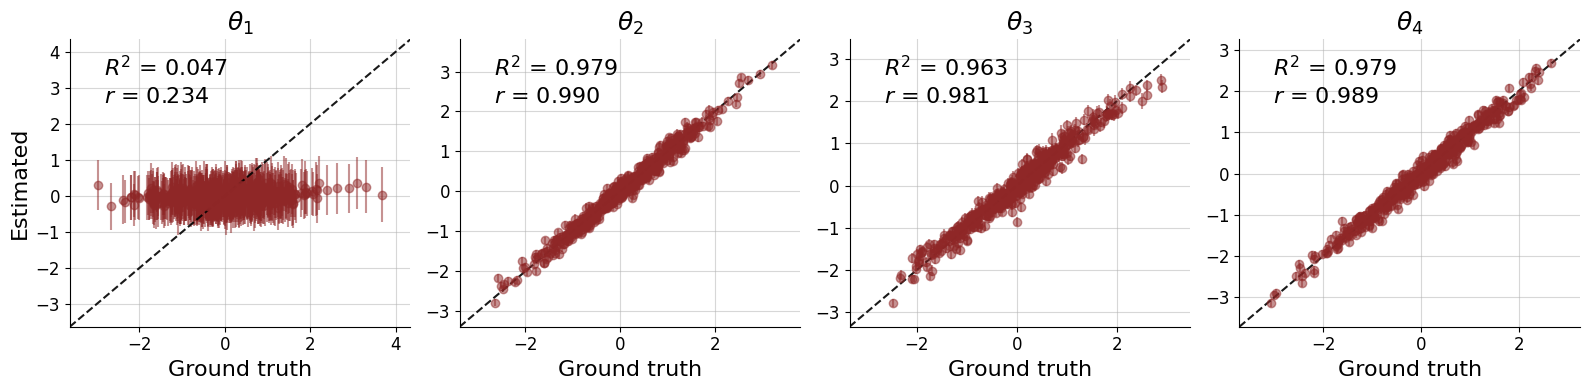

In [61]:
f = bf.diagnostics.plot_recovery(posterior_samples, test_sims["parameters"])

### Posterior z-score and contraction

- Posterior z-score: It measures how many standard deviations away the mean of the posterior distribution is from the true value of the parameter. A z-score of 0 indicates the mean perfectly aligns with the true value (no bias) while positive/negative z-scores indicate positive/negative bias, respectively.

- Posterior contraction: It measures how much the posterior distribution contracts around the true value of the parameter as more data is observed. A higher contraction indicates that the data provides strong evidence, narrowing the uncertainty range.

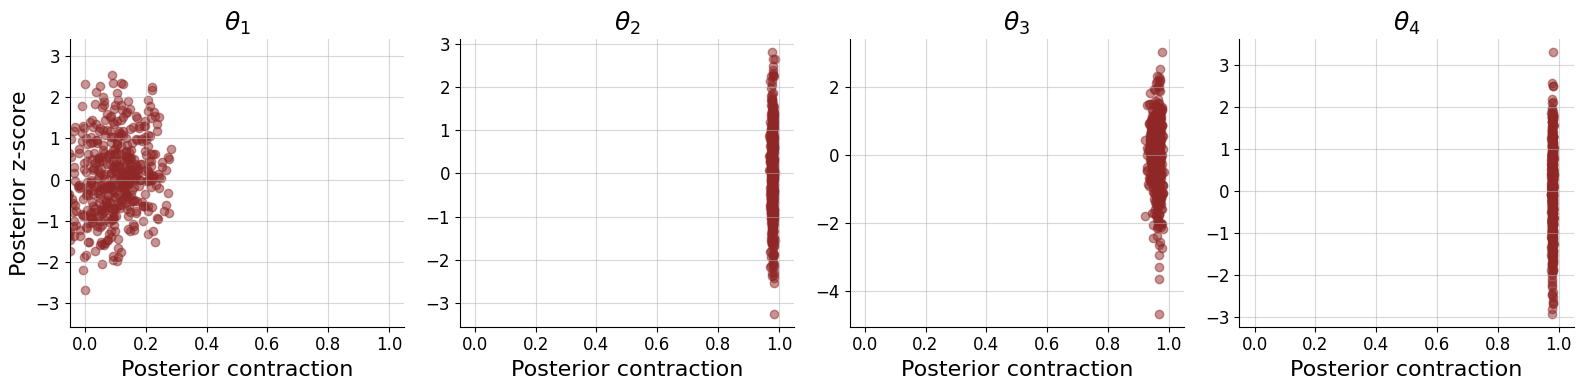

In [63]:
f = bf.diagnostics.plot_z_score_contraction(posterior_samples, test_sims["parameters"])

We can see from these diagnosts that for the first mean the network isn't doing so well, there is little bias, but basically no contraction.

# Summary

>During the training phase, only the model (i.e., simulator and prior) is used to jointly train the summary and inference networks. A parameter vector $\theta$ is sampled from the prior distribution and then fed to the simulator. The simulator returns $N$ counts of $x$ vectors that serve as input to the summary network. The right panel illustrates the inference phase. During this phase, arbitrarily many actually observed data sets can be fed through the networks to obtain posteriors

![Overview Image](https://bayesflow.org/_images/bayesflow_overview.png)